# 论文名: A hybrid classical-quantum approach for multi-class classification

## 项目介绍

论文中利用变分量子线路实现了三组数据集(Iris dataset, Bankonte Authentication dataset 和 Wireless Indoor Localization dataset)的分类

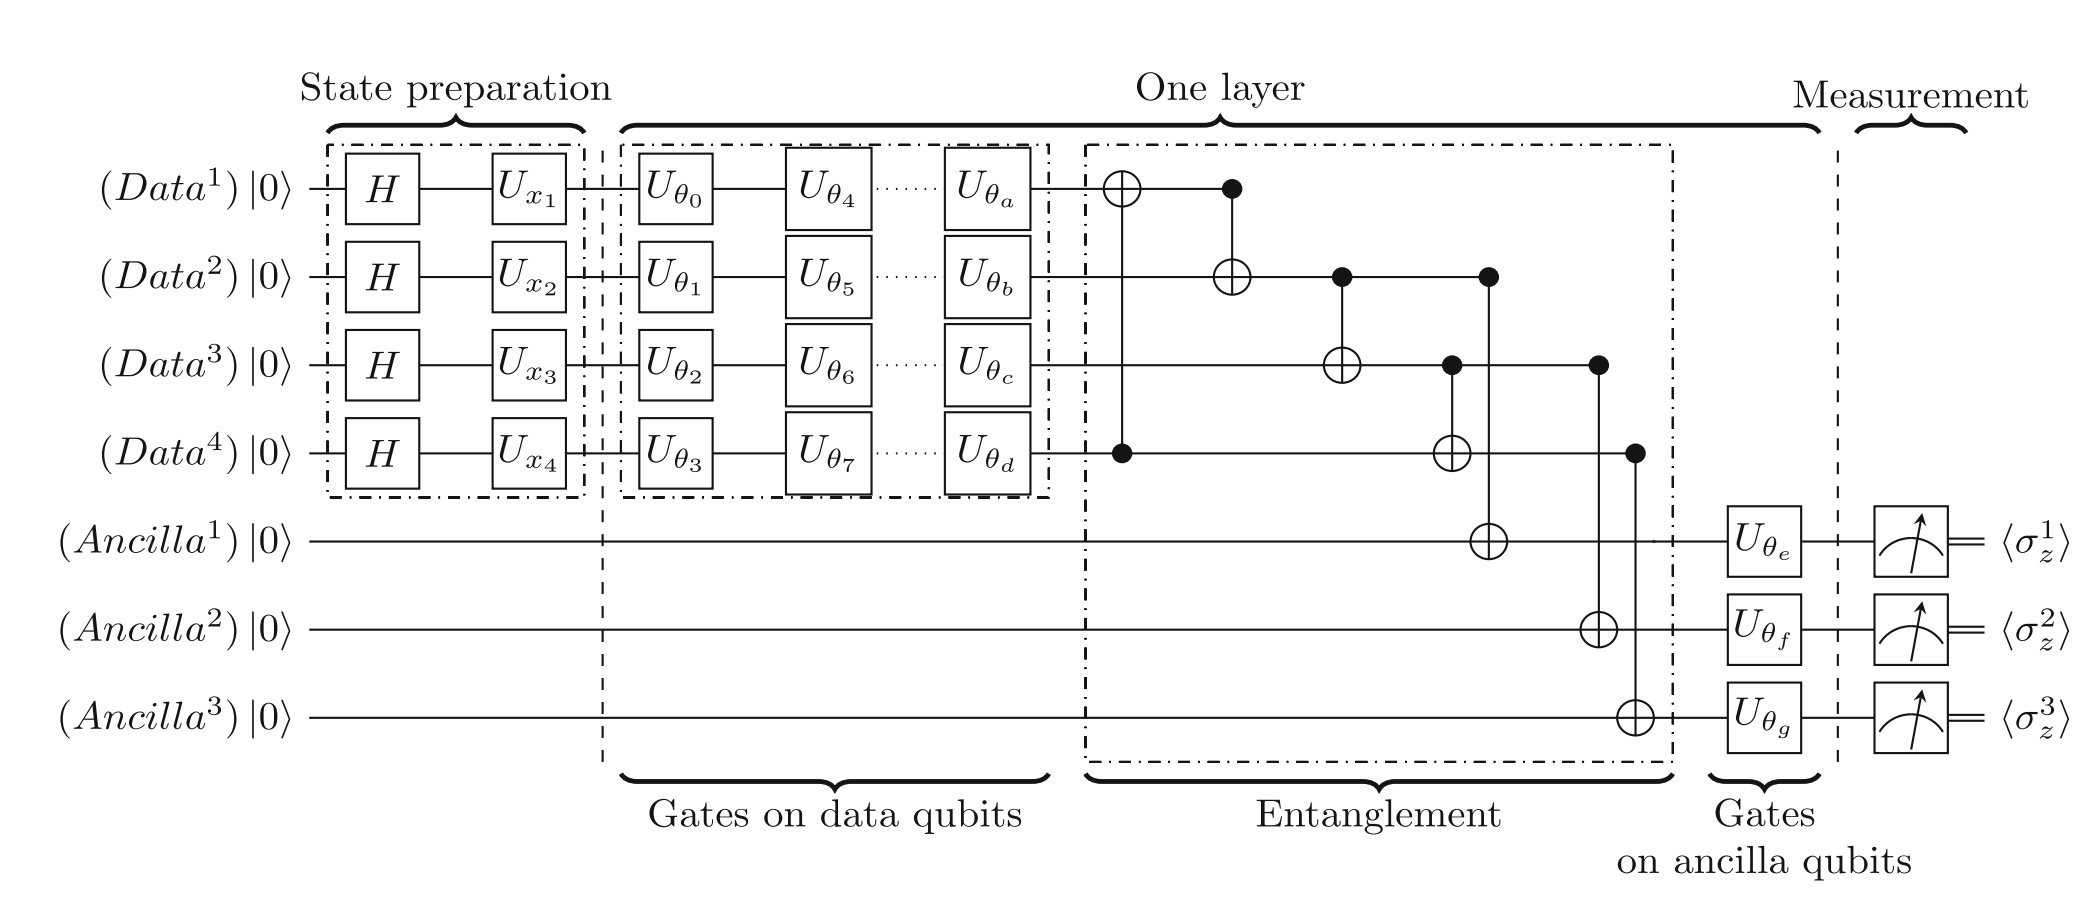

In [18]:
from IPython.display import Image
Image('/home/user/mindquantum/paper_recurrence/论文35_Mr_Tang754/src/图片.jpeg')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt        
plt.rcParams["figure.dpi"]=120                                                   

from mindquantum.core import Circuit, UN, H, X, RZ, RY, RX , BarrierGate 
from mindquantum.core import QubitOperator                    
from mindquantum.core import Hamiltonian   

import mindspore as ms                                                                        
from mindquantum.framework import MQLayer                                                     
from mindquantum.simulator import Simulator
from mindspore.nn import SoftmaxCrossEntropyWithLogits                        
from mindspore.nn import Adam, Accuracy                                        
from mindspore import Model                                                    
from mindspore.dataset import NumpySlicesDataset                           
from mindspore.train.callback import Callback, LossMonitor  
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.simulator import Simulator
from mindspore import ops, Tensor                                          


## 导入 Iris  数据

In [2]:
data_iris = pd.read_csv('/home/user/mindquantum/paper_recurrence/论文35_Mr_Tang754/src/iris.data', sep='  ', names=['类'])
datas_iris = data_iris.to_numpy()
print("前5个 Iris 数据")
print(data_iris.head())
print("Iris 数据的维度: ", datas_iris.shape)

前5个 Iris 数据
                             类
0  5.1,3.5,1.4,0.2,Iris-setosa
1  4.9,3.0,1.4,0.2,Iris-setosa
2  4.7,3.2,1.3,0.2,Iris-setosa
3  4.6,3.1,1.5,0.2,Iris-setosa
4  5.0,3.6,1.4,0.2,Iris-setosa
Iris 数据的维度:  (150, 1)


### 把输入的数据做归一化, 每个特征数据的在 0 到 $\pi/2$ 之间
$
X_i = \frac{\pi}{2}\times\frac{X_i - X_{min}}{X_{max} - X_{min}}
$

In [3]:
# 对输入的数据的最大值和最小值做归一化处理
def min_max_scaling(x, x_min, x_max):
    
    x_norm = np.pi*(x - x_min)/(2*x_max - 2*x_min)
    
    return x_norm

# 找到数据每个特征的最大值和最小值
def max_min(data):

    feature = data.shape[1]
    x_max = np.array([max(data[:,i]) for i in range(feature)])
    x_min = np.array([min(data[:,i]) for i in range(feature)])

    return x_max, x_min

# 对于 amplititude encoding 编码方式做归一化处理
# 例如 [2, 2] 变为  [0.5, 0.5]
def normolize(data):

    denominator = sum(data**2)
    return data**2/denominator

## 利用 Amplititude encoding 模块的到每个数据的输入
def amplitude_data_transform(data):

    data_transfrom = []
    sim = Simulator('projectq', 3)
    encoder, parameterResolver = amplitude_encoder(data, 3)
    sim.apply_circuit(encoder, parameterResolver)
    for i in parameterResolver.values():
        data_transfrom.append(i)
    return data_transfrom

# 打乱数据集
def shuffle_data(data, data_label, num, remomolize=False):

    data_len = len(data)
    index = np.arange(data_len)
    np.random.shuffle(index)  # 将数组打乱
    training_data = []
    training_label = []
    for i in range(data_len):
        if remomolize==False:
            training_data.append(data[index[i]])
            training_label.append(data_label[index[i]])
        else:
            training_data.append(amplitude_data_transform(normolize(data[index[i]])))
            training_label.append(data_label[index[i]])
    return np.array(training_data)[:num, :], np.array(training_label).astype(int)[:num], np.array(training_data)[num:, :], np.array(training_label).astype(int)[num:]


### 文章中给出的量子编发方式, $U_1 H|0\rangle$, 我认为数据已经做了归一化处理并且范围在 0 到 $\pi/2$ ,可以直接用$R_y(2 x_n)$来编码
\begin{equation}  
U_1 H|0\rangle    = 
\left[               
  \begin{array}{ccc}   
    \cos(\frac{\pi}{4} - x_n) & -\sin(\frac{\pi}{4} - x_n) \\  
    \cos(\frac{\pi}{4} - x_n) & \sin(\frac{\pi}{4} - x_n)  \\  
  \end{array}
\right]    
\left[               
  \begin{array}{ccc}   
    \frac{1}{\sqrt{2}}  \\  
    \frac{1}{\sqrt{2}}   \\  
  \end{array}
\right]     
=\left[               
  \begin{array}{ccc}   
    \cos(x_n)  \\  
    \sin(x_n)   \\  
  \end{array}
\right]            
\end{equation}

### 下面是对得到 Iris  数据

In [4]:
datas_iris_rescaling = np.zeros((len(datas_iris),4))
datas_iris_label = np.zeros((len(datas_iris)))

for i, value in enumerate(datas_iris):
    value = value[0].split(',')
    for j in range(4):
        datas_iris_rescaling[i,j] = value[j]
    if value[-1] == 'Iris-setosa': datas_iris_label[i] = 0
    elif value[-1] =='Iris-versicolor': datas_iris_label[i] = 1
    elif value[-1] == 'Iris-virginica': datas_iris_label[i] = 2
                  
for j in range(4):
    for i in range(len(datas_iris_rescaling)):
        x = datas_iris_rescaling[i,j]
        x_max, x_min = max_min(datas_iris_rescaling)
        datas_iris_rescaling[i,j] = 2*min_max_scaling(x, x_min[j], x_max[j]) 

### 把数据打乱, 将训练数据分为训练集和测试集

In [5]:
training_data_iris_qmcc, training_label_iris_qmcc, test_data_iris_qmcc, test_label_iris_qmcc = shuffle_data(datas_iris_rescaling, datas_iris_label, 120, remomolize=False)
training_data_iris_AEM, training_label_iris_AEM, test_data_iris_AEM, test_label_iris_AEM = shuffle_data(datas_iris_rescaling, datas_iris_label, 120, remomolize=True)

print("Iris 训练集的维度: ", training_data_iris_qmcc.shape)                                            
print("Iris 训练集标签的维度: ", training_label_iris_qmcc.shape)       
print("Iris 测试集的维度: ", test_data_iris_qmcc.shape)                                            
print("Iris 测试集标签的维度: ", test_label_iris_qmcc.shape)         

Iris 训练集的维度:  (120, 4)
Iris 训练集标签的维度:  (120,)
Iris 测试集的维度:  (30, 4)
Iris 测试集标签的维度:  (30,)


### 量子编码器，将经典数据转化为量子数据， 变分量子线路先将 $R_y(\theta)$ 旋转门作用在编码器上，然后用CNOT门将 数据比特和辅助比特纠缠在一起，在辅助比特上作用  $R_z(\theta), R_y(\theta), R_z(\theta)$ 门。将编码器和变分量子线路合并在一起，并在线路的最后的辅助比特上施加泡利 $Z$ 算符

### Iris 数据的量子线路  quantummulti-class classifier (QMCC)

In [6]:
encoder_iris_qmcc = Circuit()                                                            
for i in range(4):                                   
    encoder_iris_qmcc += RY(f'alpha{i}').on(i)                
encoder_iris_qmcc = encoder_iris_qmcc.no_grad()                          

ansatz_iris_qmcc = Circuit()                                  
for i in range(7):
    for j in range(4):                                  
        ansatz_iris_qmcc += RY(f'beta{j+7*i}').on(j)   
              
    ansatz_iris_qmcc += X.on(0, 3)                          # X门作用在第j+1位量子比特，受第j位量子比特控制
    for k in range(3):
        ansatz_iris_qmcc += X.on(k+1,k)
    ansatz_iris_qmcc += X.on(4,1)
    ansatz_iris_qmcc += X.on(5,2)
    ansatz_iris_qmcc += X.on(6,3)
    ansatz_iris_qmcc += RZ(f'beta{4+7*i}').on(4)
    ansatz_iris_qmcc += RY(f'beta{5+7*i}').on(5)
    ansatz_iris_qmcc += RZ(f'beta{6+7*i}').on(6)

circuit_iris_qmcc = encoder_iris_qmcc + ansatz_iris_qmcc       
circuit_iris_qmcc.summary()        
hams_qmcc = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [4, 5, 6]]  
print(hams_qmcc)                 
circuit_iris_qmcc

============================================Circuit Summary============================================
|Total number of gates  : 102.                                                                        |
|Parameter gates        : 53.                                                                         |
|with 53 parameters are : alpha0, alpha1, alpha2, alpha3, beta0, beta1, beta2, beta3, beta4, beta5... |
|Number qubit of circuit: 7                                                                           |
[1.0 [Z4] , 1.0 [Z5] , 1.0 [Z6] ]


q0: ──RY(alpha0)────RY(beta0)────X────●────RY(beta7)──────────────────────────────────────────────────────X────●────RY(beta14)────────────────────────────────────────────────────────X────●────RY(beta21)────────────────────────────────────────────────────────X────●────RY(beta28)────────────────────────────────────────────────────────X────●────RY(beta35)────────────────────────────────────────────────────────X────●────RY(beta42)────────────────────────────────────────────────────────X────●─────────────────────────────────────────
                                 │    │                                                                   │    │                                                                      │    │                                                                      │    │                                                                      │    │                                                                      │    │                                                                      │    │
q1: ──RY(alpha1)────RY(beta1)────┼────X────────●─────────────●────RY(beta8)───────────────────────────────┼────X────────●──────────────●────RY(beta15)────────────────────────────────┼────X────────●──────────────●────RY(beta22)────────────────────────────────┼────X────────●──────────────●────RY(beta29)────────────────────────────────┼────X────────●──────────────●────RY(beta36)────────────────────────────────┼────X────────●──────────────●────RY(beta43)────────────────────────────────┼────X────●─────────●──────────────────────────
                                 │             │             │                                            │             │              │                                              │             │              │                                              │             │              │                                              │             │              │                                              │             │              │                                              │         │         │
q2: ──RY(alpha2)────RY(beta2)────┼─────────────X────────●────┼────────●────────RY(beta9)──────────────────┼─────────────X─────────●────┼────────●─────────RY(beta16)──────────────────┼─────────────X─────────●────┼────────●─────────RY(beta23)──────────────────┼─────────────X─────────●────┼────────●─────────RY(beta30)──────────────────┼─────────────X─────────●────┼────────●─────────RY(beta37)──────────────────┼─────────────X─────────●────┼────────●─────────RY(beta44)──────────────────┼─────────X────●────┼────●─────────────────────
                                 │                      │    │        │                                   │                       │    │        │                                     │                       │    │        │                                     │                       │    │        │                                     │                       │    │        │                                     │                       │    │        │                                     │              │    │    │
q3: ──RY(alpha3)────RY(beta3)────●──────────────────────X────┼────────┼────────────●────────RY(beta10)────●───────────────────────X────┼────────┼─────────────●─────────RY(beta17)────●───────────────────────X────┼────────┼─────────────●─────────RY(beta24)────●───────────────────────X────┼────────┼─────────────●─────────RY(beta31)────●───────────────────────X────┼────────┼─────────────●─────────RY(beta38)────●───────────────────────X────┼────────┼─────────────●─────────RY(beta45)────●──────────────X────┼────┼────●────────────────
                                                             │        │            │                                                   │        │             │                                                    │        │             │                                                    │        │             │                                       

### Iris 数据的量子线路  Amplitude embedding model (AEM)

In [7]:
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.simulator import Simulator
sim = Simulator('projectq', 3)
encoder_irs_AEM, parameterResolver = amplitude_encoder(training_data_iris_AEM[0], 3)

ansatz_iris_AEM = Circuit()    

for i in range(7):
    for j in range(3):                                  
        ansatz_iris_AEM += RY(f'beta{j+3*i}').on(j) 
    ansatz_iris_AEM += X.on(1,0)
    ansatz_iris_AEM += X.on(2,1)
     
circuit_iris_AEM = encoder_irs_AEM + ansatz_iris_AEM       
circuit_iris_AEM.summary()        
hams_AEM = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0, 1, 2]]  
print(hams_AEM)                 
circuit_iris_AEM

=============================================Circuit Summary=============================================
|Total number of gates  : 52.                                                                           |
|Parameter gates        : 28.                                                                           |
|with 28 parameters are : alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, beta0, beta1, beta2...|
|Number qubit of circuit: 3                                                                             |
[1.0 [Z0] , 1.0 [Z1] , 1.0 [Z2] ]


q0: ──RY(alpha0)────X────────●─────────X────────●─────────X────────●─────────X────X────────●─────────X────────●──────────────────●─────────RY(beta0)────●────RY(beta3)─────────────────●────RY(beta6)─────────────────●────RY(beta9)──────────────────●────RY(beta12)──────────────────●────RY(beta15)──────────────────●────RY(beta18)──────────────────●───────
                             │                  │                  │                       │                  │                  │                      │                              │                              │                               │                                │                                │                                │
q1: ─────────────────────RY(alpha1)─────────RY(alpha2)────X────────●─────────X─────────────●─────────X────────●─────────X────────●─────────RY(beta1)────X────────●────────RY(beta4)────X────────●────────RY(beta7)────X────────●────────RY(beta10)────X────────●─────────RY(beta13)────X────────●─────────RY(beta16)────X────────●─────────RY(beta19)────X────●──
                                                                   │                       │                  │                  │                               │                              │                              │                               │                                │                                │                            │
q2: ───────────────────────────────────────────────────────────RY(alpha3)──────────────RY(alpha4)─────────RY(alpha5)─────────RY(alpha6)────RY(beta2)─────────────X────────RY(beta5)─────────────X────────RY(beta8)─────────────X────────RY(beta11)─────────────X─────────RY(beta14)─────────────X─────────RY(beta17)─────────────X─────────RY(beta20)─────────X──

## 搭建量子网络

In [8]:
def QuantumNet(circuit, encoder, ansatz, hams):

    ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
    ms.set_seed(1)                                                                                
    sim = Simulator('projectq', circuit.n_qubits)
    grad_ops = sim.get_expectation_with_grad(hams,
                                            circuit,
                                            None,
                                            None,
                                            encoder.params_name,
                                            ansatz.params_name,
                                            parallel_worker=5)
    QuantumNets = MQLayer(grad_ops) 
    return    QuantumNets  

QuantumNet_Iris_AEM = QuantumNet(circuit_iris_AEM, encoder_irs_AEM, ansatz_iris_AEM, hams_AEM)
QuantumNet_Iris_QMCC = QuantumNet(circuit_iris_qmcc, encoder_iris_qmcc, ansatz_iris_qmcc, hams_qmcc)
print(QuantumNet_Iris_QMCC)
print(QuantumNet_Iris_AEM)

MQLayer<
  (evolution): MQOps<7 qubits projectq VQA Operator>
  >
MQLayer<
  (evolution): MQOps<3 qubits projectq VQA Operator>
  >


## 用 Mindspore 进行训练

In [9]:
def data_load(training_data, training_label, test_data, test_label):

    train_loader = NumpySlicesDataset({'features': training_data, 'labels': training_label}, shuffle=False).batch(5) 
    test_loader = NumpySlicesDataset({'features': test_data, 'labels': test_label}).batch(5) 
    return train_loader, test_loader

def model_structure(QuantumNet):

    loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            
    opti = Adam(QuantumNet.trainable_params(), learning_rate=0.02)               
    model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})     
    return  loss, opti, model   

class StepAcc(Callback):                                                        
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader  = data_loader
        self.acc = []
        
    def step_end(self, run_context):
        self.acc.append(self.model.eval(self.data_loader, dataset_sink_mode=False)['Acc'])

In [10]:
train_loader_qmcc, test_loader_qmcc = data_load(training_data_iris_qmcc, training_label_iris_qmcc, test_data_iris_qmcc, test_label_iris_qmcc)
loss_qmcc, opti_qmcc, model_qmcc  = model_structure(QuantumNet_Iris_QMCC)

monitor = LossMonitor(24)         
acc_train_iris_qmcc = StepAcc(model_qmcc, train_loader_qmcc)     
acc_test_iris_qmcc = StepAcc(model_qmcc, test_loader_qmcc)  

model_qmcc.train(10, train_loader_qmcc, callbacks=[monitor, acc_train_iris_qmcc, acc_test_iris_qmcc ], dataset_sink_mode=False)
print("The training of mode qmcc is finished")


[WARNING] DEBUG(27214,7f3617f39740,python):2022-02-15-03:53:51.961.292 [mindspore/ccsrc/debug/debugger/debugger.cc:88] Debugger] Not enabling debugger. Debugger does not support CPU.
epoch: 1 step: 24, loss is 0.9471219
epoch: 2 step: 24, loss is 0.828481
epoch: 3 step: 24, loss is 0.7767044
epoch: 4 step: 24, loss is 0.7413459
epoch: 5 step: 24, loss is 0.71480644
epoch: 6 step: 24, loss is 0.6935609
epoch: 7 step: 24, loss is 0.6706374
epoch: 8 step: 24, loss is 0.65050685
epoch: 9 step: 24, loss is 0.6393563
epoch: 10 step: 24, loss is 0.6309694
The training of mode qmcc is finished


In [13]:
train_loader_AEM, test_loader_AEM = data_load(training_data_iris_AEM, training_label_iris_AEM, test_data_iris_AEM, test_label_iris_AEM)
loss_AEM, opti_AEM, model_AEM  = model_structure(QuantumNet_Iris_AEM)

acc_train_iris_AEM = StepAcc(model_AEM, train_loader_AEM)     
acc_test_iris_AEM = StepAcc(model_AEM, test_loader_AEM)    

model_AEM.train(10, train_loader_AEM, callbacks=[monitor, acc_train_iris_AEM, acc_test_iris_AEM ], dataset_sink_mode=False)
print("The training of mode AME is finished")

epoch: 1 step: 24, loss is 0.9213594
epoch: 2 step: 24, loss is 0.8104768
epoch: 3 step: 24, loss is 0.7782162
epoch: 4 step: 24, loss is 0.76242626
epoch: 5 step: 24, loss is 0.75557286
epoch: 6 step: 24, loss is 0.7529279
epoch: 7 step: 24, loss is 0.7512976
epoch: 8 step: 24, loss is 0.7499302
epoch: 9 step: 24, loss is 0.74872905
epoch: 10 step: 24, loss is 0.7475784
The training of mode AME is finished


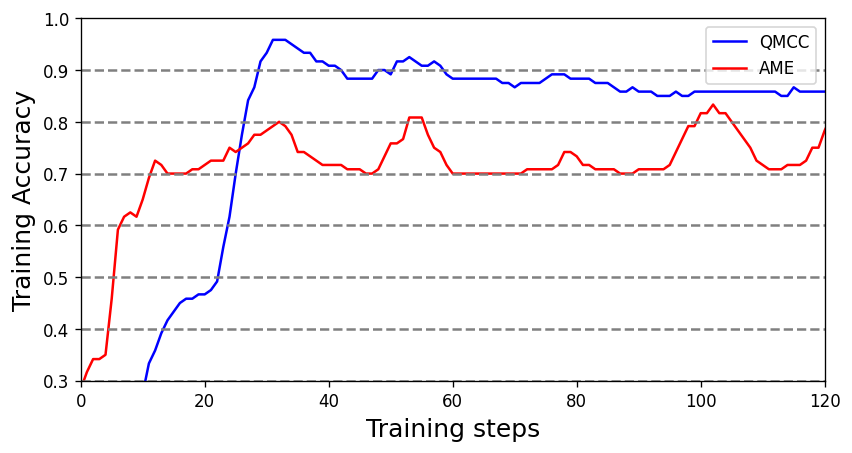

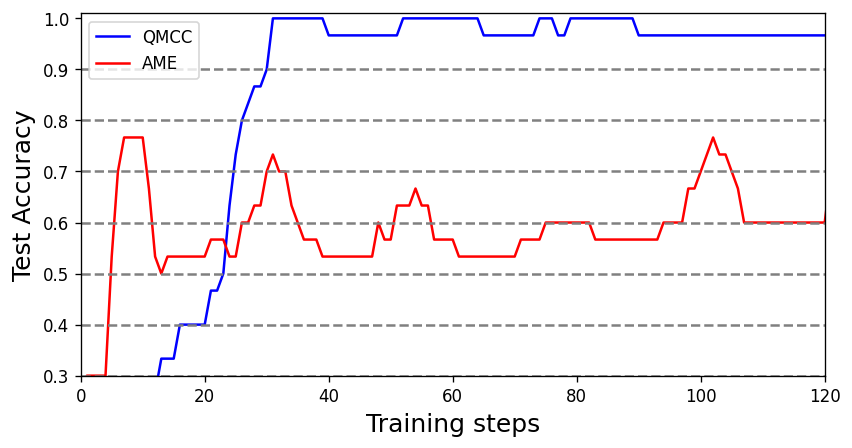

In [14]:
def plot(acc_train_qmcc, acc_test_qmcc, acc_train_amd, acc_test_amd):

    fig = plt.figure(figsize=(8,4))
    plt.plot(acc_train_qmcc.acc, color='b', label='QMCC')
    plt.plot(acc_train_amd.acc, color='r', label='AME')
    for i in np.arange(0.3, 0.9, 0.1):
        plt.axhline(i, color='gray', linestyle='--')
    plt.xlabel('Training steps', fontsize=15)
    plt.ylabel('Training Accuracy', fontsize=15)
    plt.xlim(0, 120)
    plt.ylim(0.3, 1)
    plt.legend()

    fig = plt.figure(figsize=(8,4))
    plt.plot(acc_test_qmcc.acc, color='b', label='QMCC')
    plt.plot(acc_test_amd.acc, color='r', label='AME')
    for i in np.arange(0.3, 0.9, 0.1):
        plt.axhline(i, color='gray', linestyle='--')
    plt.xlabel('Training steps', fontsize=15)
    plt.ylabel('Test Accuracy', fontsize=15)
    plt.xlim(0, 120)
    plt.ylim(0.3, 1.01)
    plt.legend()

    return plt.show()

plot(acc_train_iris_qmcc, acc_test_iris_qmcc, acc_train_iris_AEM, acc_test_iris_AEM)

In [15]:
def accuracy(model_qmcc, model_AEM, test_loader_qmcc, test_load_amd):

    correct_qmcc = model_qmcc.eval(test_loader_qmcc, dataset_sink_mode=False) 
    correct_AME = model_AEM.eval(test_load_amd, dataset_sink_mode=False) 

    return   correct_qmcc,   correct_AME        

correct_qmcc,   correct_AME  = accuracy(model_qmcc, model_AEM, test_loader_qmcc, test_loader_AEM)     
print("Test accuracy on Iris dataset of QMCC: %.3f"%(correct_qmcc["Acc"]) )
print("Test accuracy on Iris dataset of AEM: %.3f"%(correct_AME["Acc"]) )                          

Test accuracy on Iris dataset of QMCC: 1.000
Test accuracy on Iris dataset of AEM: 0.700
